# Dataset Preparation for First ICU Prediction

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import spacy

import seaborn as sns
sns.set(style = 'darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

In [3]:
path = Path('./data')
raw_csv = path/'mimic_icu_pred_raw_dataset.csv'
proc_csv = path/'mimic_icu_pred_proc_dataset.csv'
fig_dir = path/'workdir/figures'

## Functions

In [4]:
def get_sample(df, sample_pct=0.01, with_val=True, seed=None):
  train = df.loc[(df['split']) == 'train'].sample(frac=sample_pct, random_state=seed)
  train.reset_index(inplace=True, drop=True)

  if with_val:
    val = df.loc[(df['split']) == 'val'].sample(frac=sample_pct, random_state=seed)
    val.reset_index(inplace=True, drop=True)
    return pd.concat([train, val], axis=0) 

  return train

In [5]:
def tokenize_text(text):
  tokens = [token.text for token in nlp(text)]
  return ' '.join(tokens)

def group_eth(eth):
  eth = eth.lower()
  if 'white' in eth:
    return 'white'
  elif 'black' in eth:
    return 'black'
  elif 'hispanic' in eth:
    return 'hispanic'
  elif 'asian' in eth:
    return 'asian'
  else:
    return 'unknown'

## Data Processing

1. Load in the data
2. Drop duplicates
3. Merge `category`, `description`, and `text` into a new column called `note`
4. Tokenize text using `scispacy` and create new column called `scispacy_note` to save tokenized text
5. Save a csv file onto disk

In [6]:
df = pd.read_csv(raw_csv)
df.shape

(76370, 23)

In [7]:
nlp = spacy.load('en_core_sci_md', disable=['parser', 'ner', 'tagger'])

df.drop_duplicates(inplace=True)
df['note'] = df['category'].str.cat(df['description'], sep='\n')
df['note'] = df['note'].str.cat(df['text'], sep='\n')
df['ethnicity'] = df['ethnicity'].apply(group_eth)
df['scispacy_note'] = df['note'].apply(tokenize_text)
df.drop(['text', 'description'], axis=1, inplace=True)
df.shape

(75271, 23)

In [8]:
df.to_csv(proc_csv, index=False)

## Data Analysis

In [9]:
df = pd.read_csv(proc_csv)
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'admission_type', 'admittime',
       'dischtime', 'intime', 'outtime', 'charttime', 'icu_los', 'deathtime',
       'adm_icu_period', 'chart_icu_period', 'chartinterval', 'ethnicity',
       'dob', 'gender', 'admission_age', 'category', 'imminent_label',
       'discharge_label', 'note', 'scispacy_note'],
      dtype='object')

In [10]:
intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, 15)]
intervals.append('t ≤ -15')

### ICU LOS Histogram

In [11]:
plot_df = df[['icu_los']]

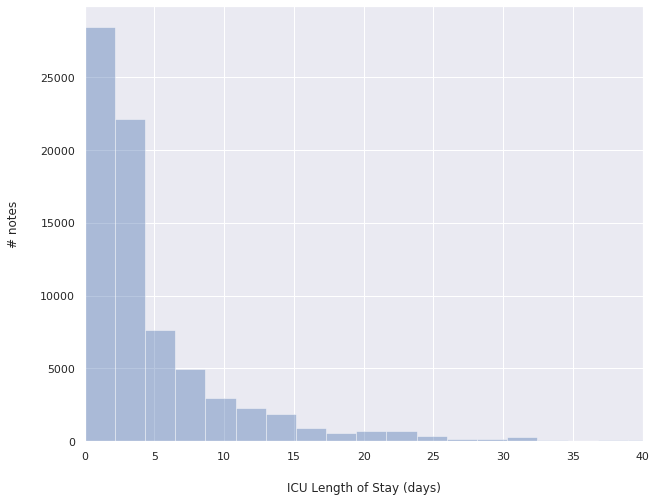

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df, kde=False, ax=ax, bins=80)
ax.set_xlabel('ICU Length of Stay (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 40)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {df['icu_los'].min()}, Avg: {df['icu_los'].mean(): 0.2f}, Max: {df['icu_los'].max()}", fontsize=15, ha='center', va='bottom')

In [13]:
# fig.savefig(fig_dir/'icu_los_hist.tif', dpi=300)

### Bar Plot of Notes Over Days

#### All Notes

In [14]:
plot_df = pd.DataFrame(df.groupby(['chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True, drop=True)
plot_df['days'] = intervals

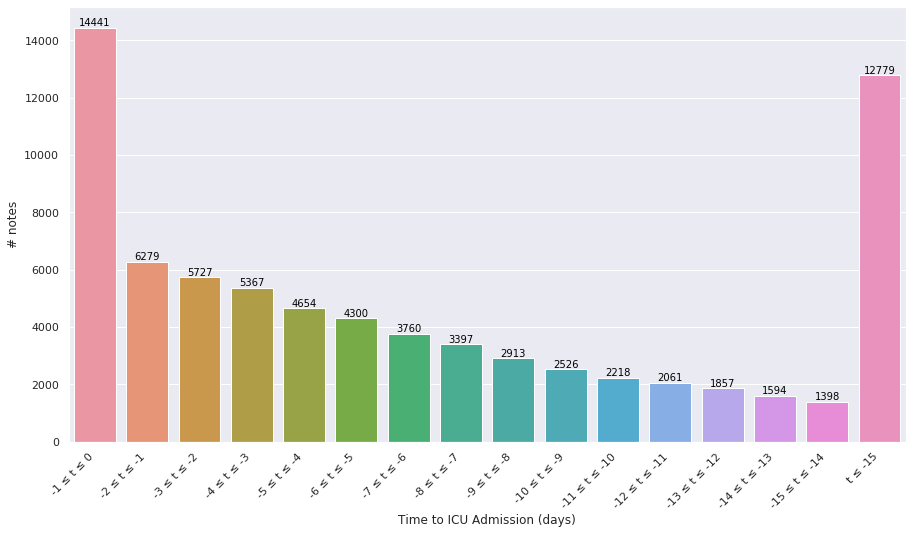

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='days', y='n_notes', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_xlabel('Time to ICU Admission (days)')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
    ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')

In [16]:
# fig.savefig(fig_dir/'note_bp.tif', dpi=300)

#### By Category

In [17]:
def plot_intervals(ax, df, cat):
  sns.barplot(x='days', y='n_notes', data=df, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}\n# notes: {df['n_notes'].sum()}")   

  for index, (_, row) in enumerate(df.iterrows()):
      ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')    

In [18]:
plot_df = pd.DataFrame(df.groupby(['category', 'chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True)
plot_df['days'] = plot_df['chartinterval'].apply(lambda x: intervals[x])
plot_df.drop(['chartinterval'], inplace=True, axis=1)

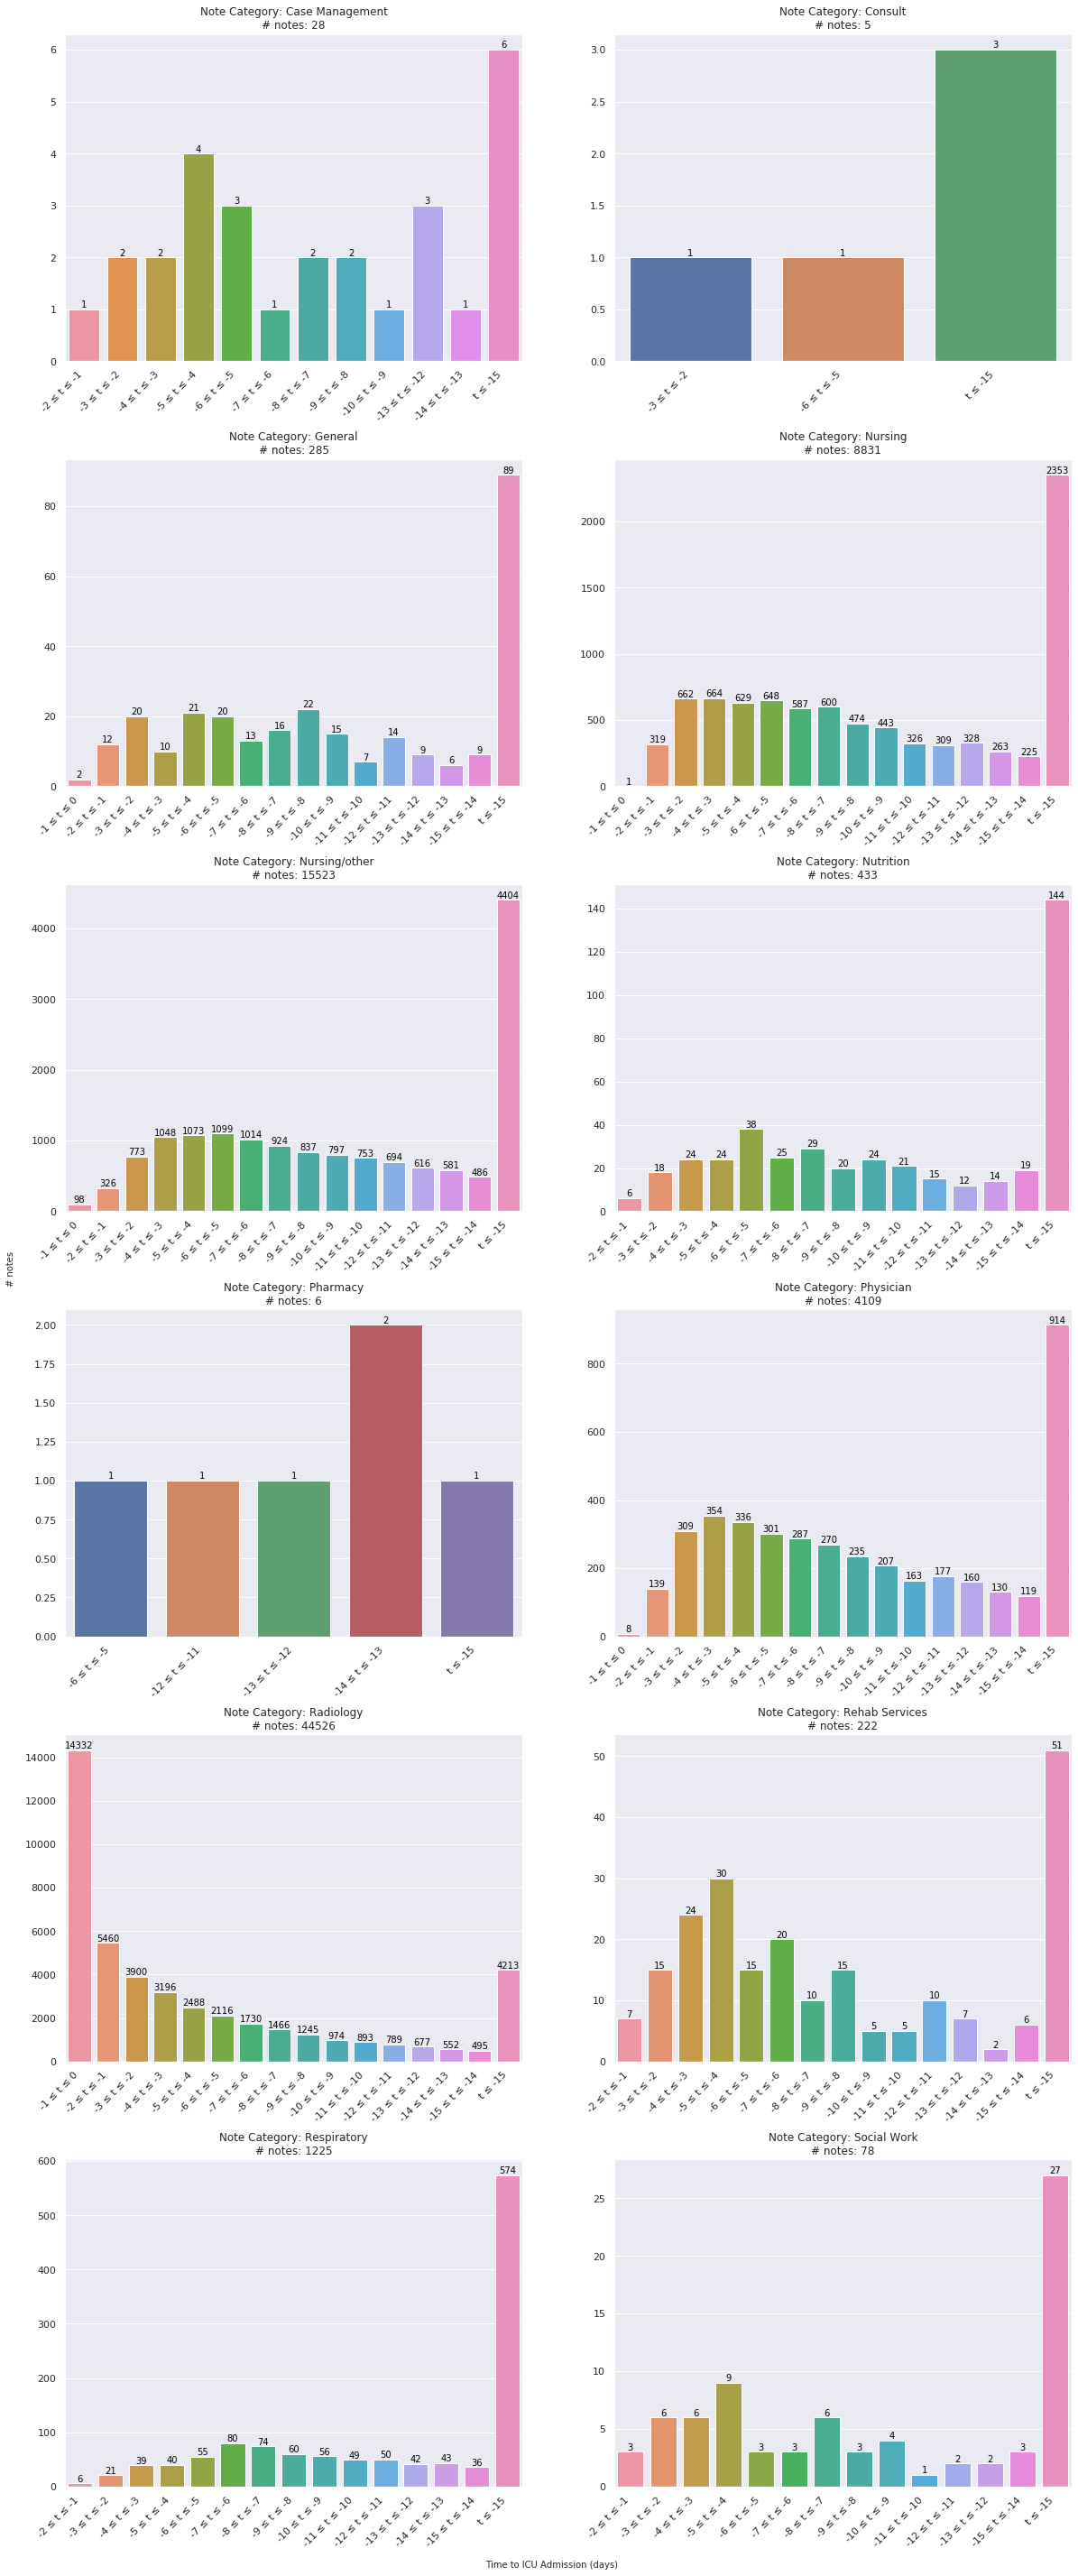

In [19]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_intervals(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['n_notes', 'days']], 'Case Management')
plot_intervals(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['n_notes', 'days']], 'Consult')

plot_intervals(ax[1][0], plot_df.loc[plot_df['category'] == 'General', ['n_notes', 'days']], 'General')
plot_intervals(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing', ['n_notes', 'days']], 'Nursing')

plot_intervals(ax[2][0], plot_df.loc[plot_df['category'] == 'Nursing/other', ['n_notes', 'days']], 'Nursing/other')
plot_intervals(ax[2][1], plot_df.loc[plot_df['category'] == 'Nutrition', ['n_notes', 'days']], 'Nutrition')

plot_intervals(ax[3][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['n_notes', 'days']], 'Pharmacy')
plot_intervals(ax[3][1], plot_df.loc[plot_df['category'] == 'Physician ', ['n_notes', 'days',]], 'Physician')

plot_intervals(ax[4][0], plot_df.loc[plot_df['category'] == 'Radiology', ['n_notes', 'days']], 'Radiology')
plot_intervals(ax[4][1], plot_df.loc[plot_df['category'] == 'Rehab Services', ['n_notes', 'days']], 'Rehab Services')

plot_intervals(ax[5][0], plot_df.loc[plot_df['category'] == 'Respiratory ', ['n_notes', 'days']], 'Respiratory')
plot_intervals(ax[5][1], plot_df.loc[plot_df['category'] == 'Social Work', ['n_notes', 'days']], 'Social Work')

fig.text(0.5, 0.1, 'Time to ICU Admission (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.3)

In [20]:
# fig.savefig(fig_dir/'note_cats_bp.tif', dpi=300)

### Note Chart Time to ICU Admission Period Histogram

#### All Notes

In [21]:
plot_df = df[['category', 'chart_icu_period']]

(0, 60)

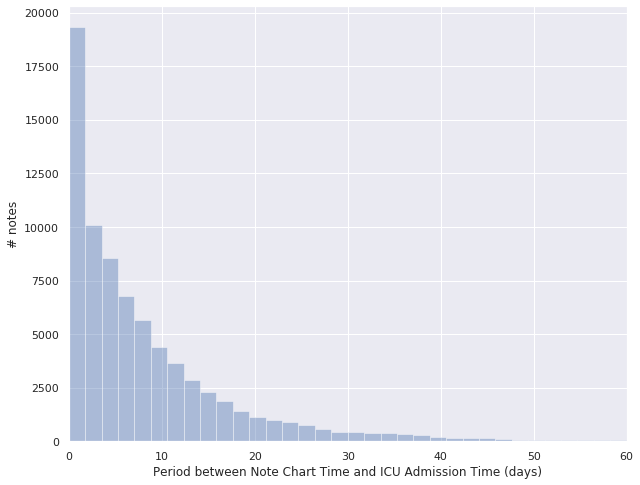

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df['chart_icu_period'], kde=False, ax=ax, bins=80)
ax.set_xlabel('Period between Note Chart Time and ICU Admission Time (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 60)

# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['chart_icu_period'].min()}, Avg: {mdf['chart_icu_period'].mean(): 0.2f}, Max: {mdf['chart_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')

In [23]:
# fig.savefig(fig_dir/'note_icu_period_hist.tif', dpi=300)

#### By Category

In [24]:
def plot_period(ax, df, cat):
  sns.distplot(df, kde=False, ax=ax, bins=10)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}")   

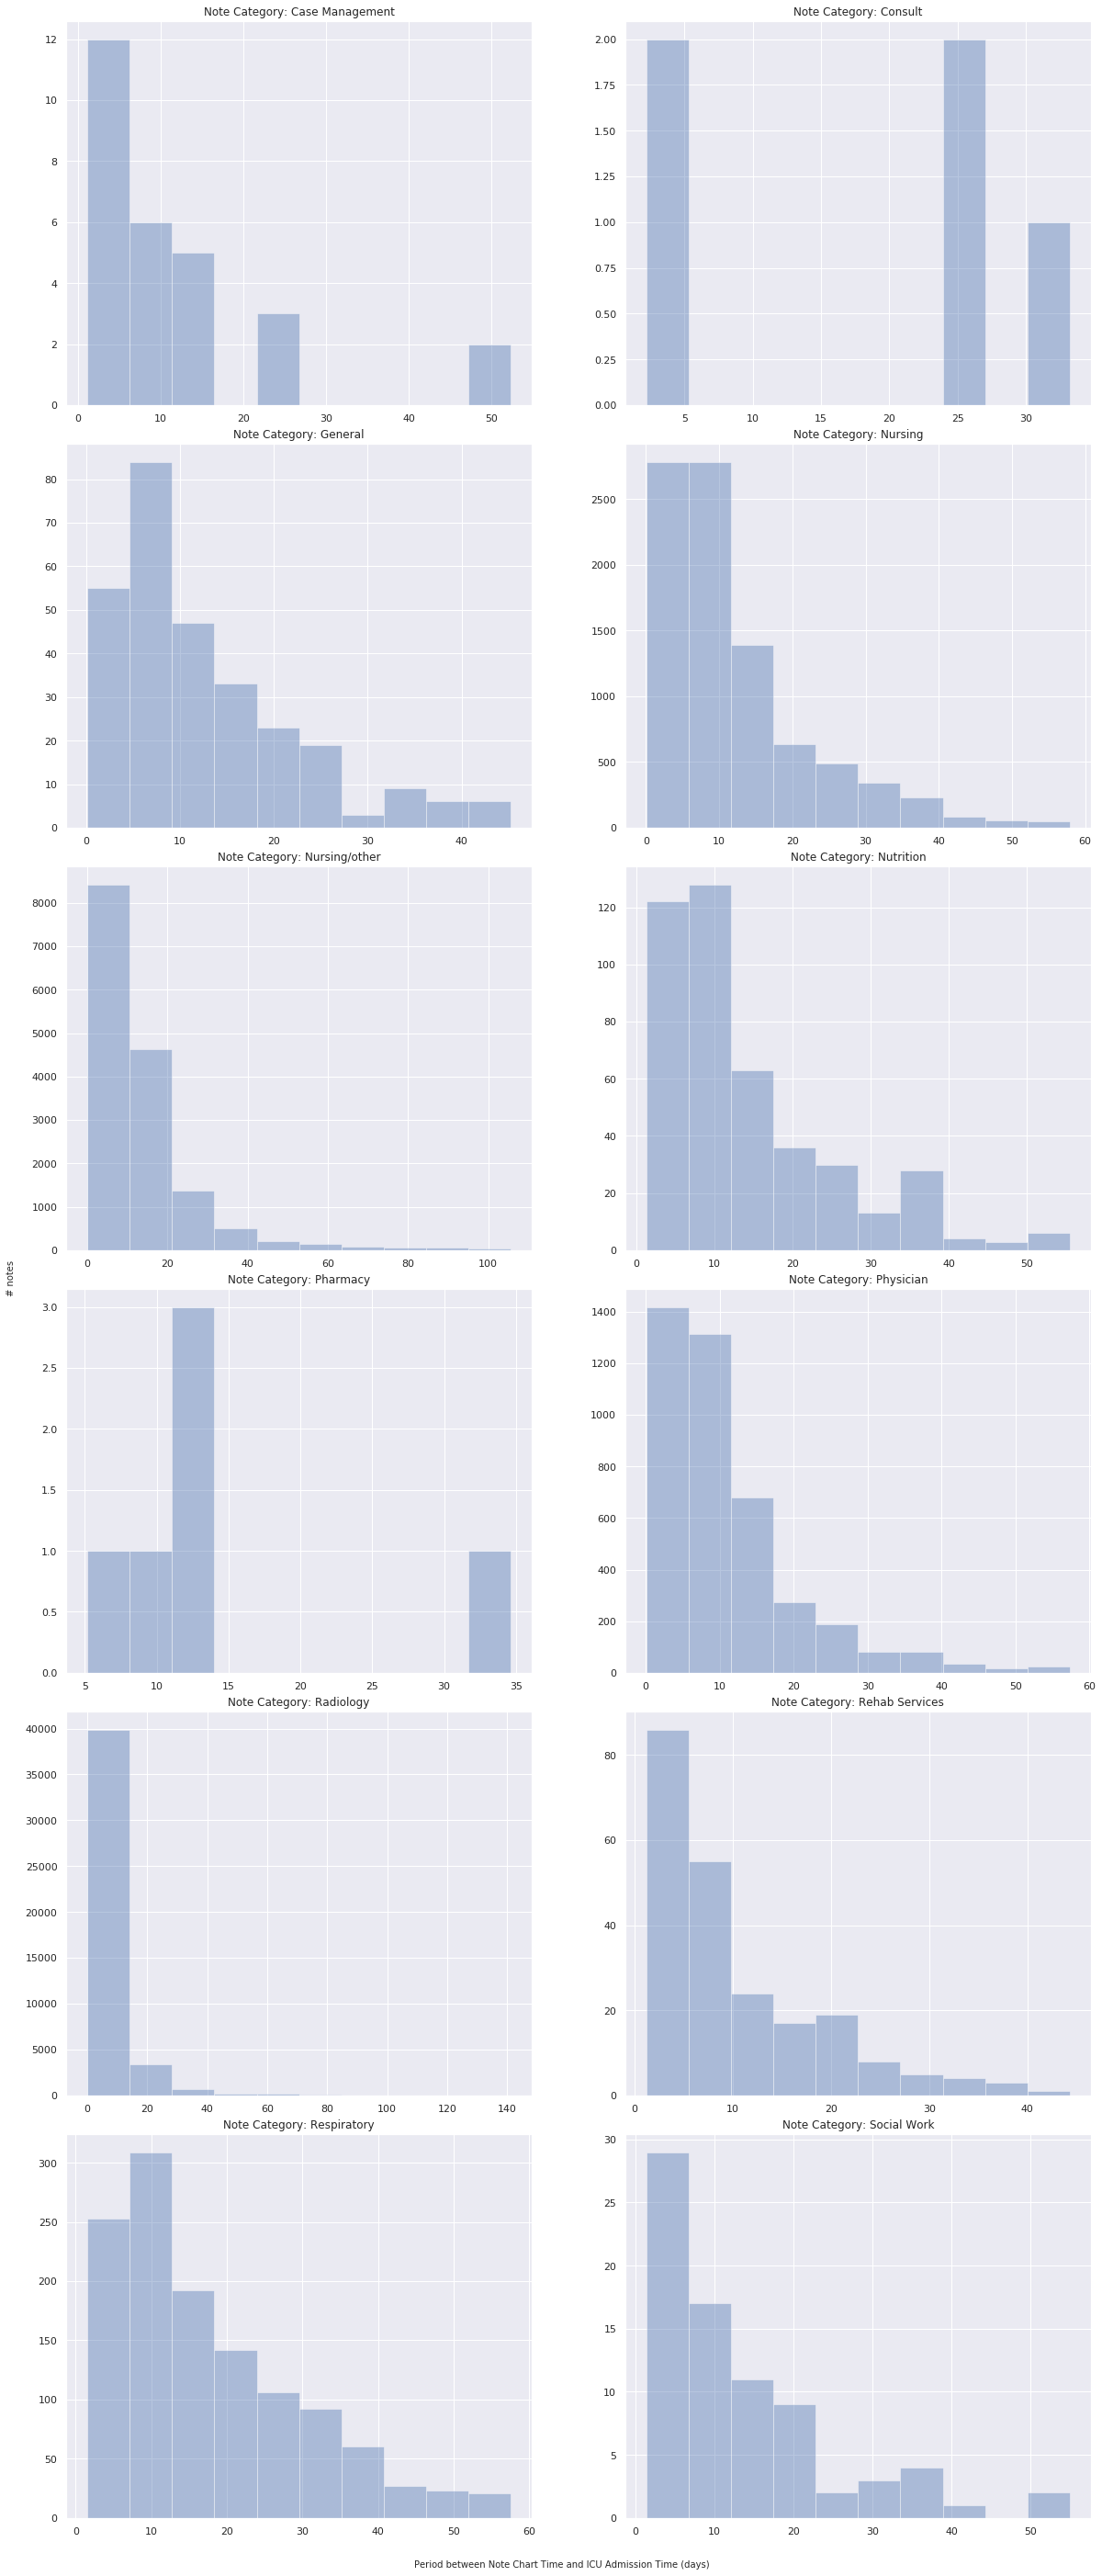

In [25]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_period(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['chart_icu_period']], 'Case Management')
plot_period(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['chart_icu_period']], 'Consult')

plot_period(ax[1][0], plot_df.loc[plot_df['category'] == 'General', ['chart_icu_period']], 'General')
plot_period(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing', ['chart_icu_period']], 'Nursing')

plot_period(ax[2][0], plot_df.loc[plot_df['category'] == 'Nursing/other', ['chart_icu_period']], 'Nursing/other')
plot_period(ax[2][1], plot_df.loc[plot_df['category'] == 'Nutrition', ['chart_icu_period']], 'Nutrition')

plot_period(ax[3][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['chart_icu_period']], 'Pharmacy')
plot_period(ax[3][1], plot_df.loc[plot_df['category'] == 'Physician ', ['chart_icu_period',]], 'Physician')

plot_period(ax[4][0], plot_df.loc[plot_df['category'] == 'Radiology', ['chart_icu_period']], 'Radiology')
plot_period(ax[4][1], plot_df.loc[plot_df['category'] == 'Rehab Services', ['chart_icu_period']], 'Rehab Services')

plot_period(ax[5][0], plot_df.loc[plot_df['category'] == 'Respiratory ', ['chart_icu_period']], 'Respiratory')
plot_period(ax[5][1], plot_df.loc[plot_df['category'] == 'Social Work', ['chart_icu_period']], 'Social Work')

fig.text(0.5, 0.11, 'Period between Note Chart Time and ICU Admission Time (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.1)

In [ ]:
# fig.savefig(fig_dir/'note_cat_icu_period_hist.tif', dpi=300)

### Hospital Admission to ICU Admission Period Histogram

In [26]:
plot_df = df[['adm_icu_period']]

(0, 70)

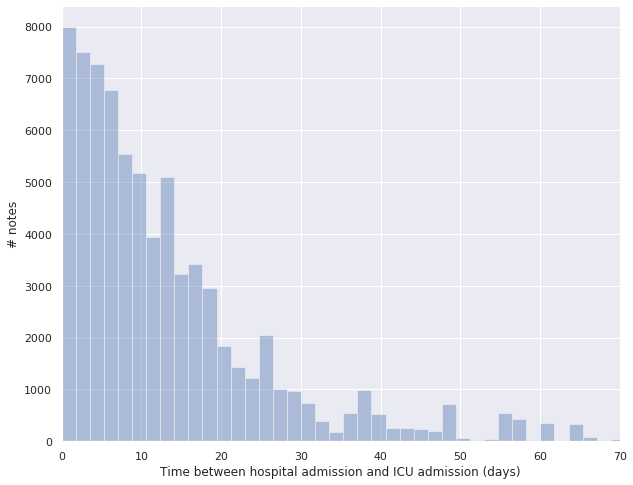

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df, kde=False, ax=ax, bins=80)
ax.set_xlabel('Time between hospital admission and ICU admission (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 70)
# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['adm_icu_period'].min()}, Avg: {mdf['adm_icu_period'].mean(): 0.2f}, Max: {mdf['adm_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')    

In [ ]:
# fig.savefig(fig_dir/'adm_icu_period_hist.tif', dpi=300)

### Note Length Histogram

Text(0, 0.5, '# notes')

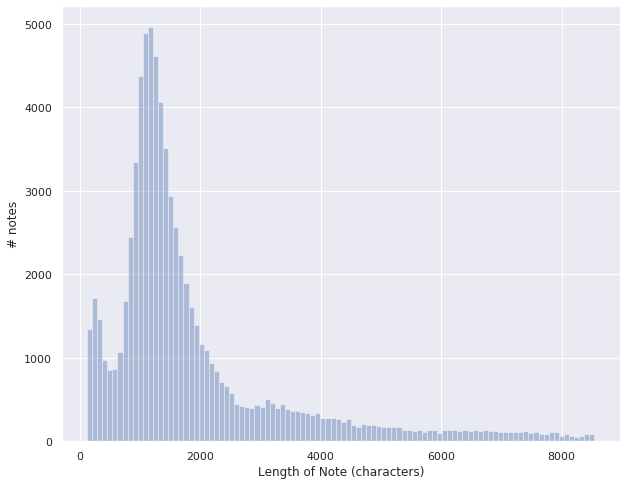

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['note'].apply(len), kde=False, ax=ax, bins=100)
ax.set_xlabel('Length of Note (characters)')
ax.set_ylabel('# notes')

In [34]:
# fig.savefig(fig_dir/'note_len_hist.tif', dpi=300)

### Imminent ICU Prediction Class Distribution

In [43]:
plot_df = pd.DataFrame(df.groupby(['imminent_label']).size(), columns=['n_notes'])

In [55]:
plot_df2.reset_index(inplace=True)

In [56]:
plot_df2.head()

,imminent_label,hadm_id,n_notes
0,-1,100009,2
1,-1,100012,1
2,-1,100018,2
3,-1,100020,2
4,-1,100021,3


In [44]:
plot_df.reset_index(inplace=True)

In [51]:
plot_df.head()

,imminent_label,n_notes
0,-1,24462
1,0,38803
2,1,12006


## Dataset Processing

In [ ]:
df = pd.read_csv(path/'raw_dataset.csv')
df.drop_duplicates(inplace=True)
df['note'] = df['category'].str.cat(df['description'], sep='\n')
df['note'] = df['note'].str.cat(df['text'], sep='\n')
df['ethnicity'] = df['ethnicity'].apply(group_eth)
df['scispacy_note'] = df['note'].apply(tokenize_text)
df.head()

In [ ]:
df.to_csv(path/'processed_dataset.csv', index=False)

In [ ]:
full_df = pd.read_csv(path/'full_raw_dataset.csv')

full_df.drop_duplicates(inplace=True)
full_df['note'] = full_df['category'].str.cat(full_df['description'], sep='\n')
full_df['note'] = full_df['note'].str.cat(full_df['text'], sep='\n')
full_df['ethnicity'] = full_df['ethnicity'].apply(group_eth)
full_df['scispacy_note'] = full_df['note'].apply(tokenize_text)
print(full_df.shape)
full_df.head()

In [ ]:
full_df.to_csv(path/'full_processed_dataset.csv', index=False)

## Stats

In [ ]:
df = pd.read_csv(path/'processed_dataset.csv')

In [ ]:
print(f"{(len(df.loc[df['class_label'] == 1])/len(df)):0.3f}")

In [ ]:
from utils.splits import set_two_splits

In [ ]:
avg_p = []

for seed in range(127, 227):
  sdf = set_two_splits(df.copy(), name='test', seed=seed)
  test_size = len(sdf.loc[(sdf['split'] == 'test')])
  test_pos = len(sdf.loc[(sdf['split'] == 'test') & (sdf['class_label'] == 1)])
  avg_p.append(test_pos/test_size)  

In [ ]:
avg_p = np.array(avg_p)

In [ ]:
print(f"Average prevalence = {(avg_p.mean()):0.3f}")

In [ ]:
print(f"Std prevalance = {(avg_p.std()):0.3f}")

In [ ]:
df.loc[(df['class_label'] == 0)].groupby('category').apply(lambda g: pd.Series(g['subject_id'].nunique()))

In [ ]:
df.loc[(df['class_label'] == 0)].groupby('category').size()